In [11]:
import tensorflow as tf
import pandas as pd
import os


In [12]:
def load_dataset(image_dir, label_file):
    df = pd.read_csv(label_file)
    image_paths = [os.path.join(image_dir, f"{img_id}.png") for img_id in df['id']]
    bone_ages = df['boneage'].values
    genders = df['male'].astype(int).values  # Ensure it's integer (0 or 1)
    return image_paths, bone_ages, genders

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256))
    return image

def create_tf_dataset(image_paths, labels, batch_size=32):
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((image_ds, label_ds)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [13]:
# Load paths and labels
train_X, train_y_bone, train_y_gender = load_dataset("Train/train_samples_pp", "Train/train_labels.csv")
val_X, val_y_bone, val_y_gender = load_dataset("Val/val_samples_pp", "Val/val_labels.csv")
test_X, test_y_bone, test_y_gender = load_dataset("Test/test_samples_pp", "Test/test_labels.csv")


In [14]:
# Create TensorFlow datasets
train_ds_X = create_tf_dataset(train_X, train_X)
val_ds_X = create_tf_dataset(val_X, val_X)
test_ds_X = create_tf_dataset(test_X, test_X)

train_ds_y_bone = tf.data.Dataset.from_tensor_slices(train_y_bone).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_y_bone = tf.data.Dataset.from_tensor_slices(val_y_bone).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_y_bone = tf.data.Dataset.from_tensor_slices(test_y_bone).batch(32).prefetch(tf.data.AUTOTUNE)

train_ds_y_gender = tf.data.Dataset.from_tensor_slices(train_y_gender).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_y_gender = tf.data.Dataset.from_tensor_slices(val_y_gender).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_y_gender = tf.data.Dataset.from_tensor_slices(test_y_gender).batch(32).prefetch(tf.data.AUTOTUNE)


In [15]:
# Define CNN Model
def CNN():
    inputs = tf.keras.Input(shape=(256, 256, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    output_boneage = tf.keras.layers.Dense(1, activation='linear', name='boneage_output')(x)
    output_gender = tf.keras.layers.Dense(1, activation='sigmoid', name='gender_output')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[output_boneage, output_gender])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={'boneage_output': 'mse', 'gender_output': 'binary_crossentropy'},
        metrics={'boneage_output': 'mae', 'gender_output': 'accuracy'}
    )

    return model

model = CNN()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_10… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 65536)     │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │ 33,554,944 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boneage_output      │ (None, 1)         │        513 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        513 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,943,810 (129.49 MB)

 Trainable params: 33,943,810 (129.49 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import matplotlib.pyplot as plt

# Fix dataset creation to include both labels
def create_combined_dataset(image_paths, bone_ages, genders, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, bone_ages, genders))
    def process(path, bone, gender):
        return preprocess_image(path), (bone, gender)
    return dataset.map(process, tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create correct datasets
train_ds = create_combined_dataset(train_X, train_y_bone, train_y_gender)
val_ds = create_combined_dataset(val_X, val_y_bone, val_y_gender)
test_ds = create_combined_dataset(test_X, test_y_bone, test_y_gender)


In [18]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 1343s 3s/step - boneage_output_loss: 2605.7874 - boneage_output_mae: 40.3942 - gender_output_accuracy: 0.5100 - gender_output_loss: 3.2477 - loss: 2609.0435 - val_boneage_output_loss: 1946.0165 - val_boneage_output_mae: 37.0739 - val_gender_output_accuracy: 0.4575 - val_gender_output_loss: 0.7852 - val_loss: 1949.0280
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 1317s 3s/step - boneage_output_loss: 1917.9445 - boneage_output_mae: 35.3755 - gender_output_accuracy: 0.4993 - gender_output_loss: 0.8754 - loss: 1918.8148 - val_boneage_output_loss: 2354.3997 - val_boneage_output_mae: 39.6795 - val_gender_output_accuracy: 0.5411 - val_gender_output_loss: 0.6906 - val_loss: 2365.4031
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 1320s 3s/step - boneage_output_loss: 1743.4301 - boneage_output_mae: 33.2975 - gender_output_accuracy: 0.5210 - gender_output_loss: 0.7531 - loss: 1744.1836 - val_boneage_output_loss: 1533.2556 - val_boneage_output_mae: 31.5071 - val_gender

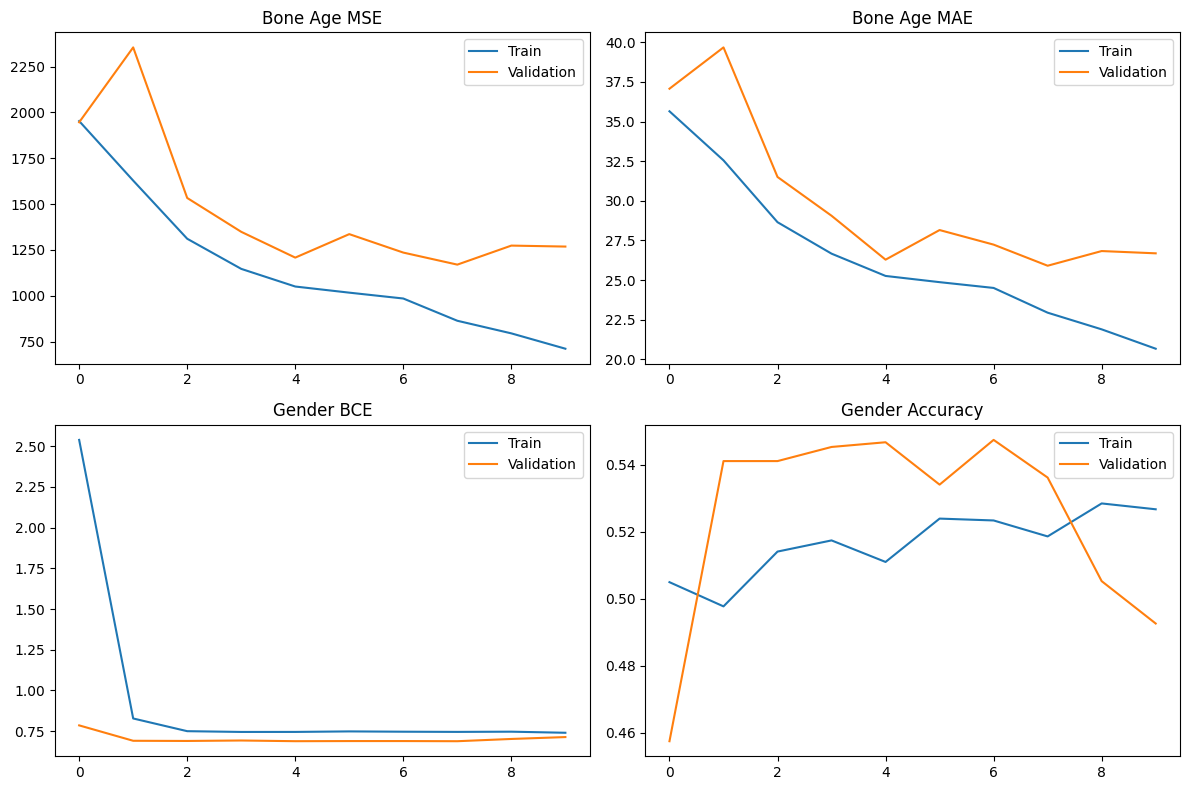

In [19]:
plt.figure(figsize=(12, 8))
metrics = ['boneage_output_loss', 'boneage_output_mae', 'gender_output_loss', 'gender_output_accuracy']
titles = ['Bone Age MSE', 'Bone Age MAE', 'Gender BCE', 'Gender Accuracy']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(history.history[metric], label='Train')
    plt.plot(history.history[f'val_{metric}'], label='Validation')
    plt.title(titles[i])
    plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# Evaluate on test set
test_results = model.evaluate(test_ds, verbose=0)
print(f"Test Bone Age MAE: {test_results[3]:.2f} months")
print(f"Test Gender Accuracy: {test_results[4]*100:.1f}%")

Test Bone Age MAE: 48.78 months
Test Gender Accuracy: 52.0%
